In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import os
from beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers

from beamline34IDC.optimization.display_utils import LivePlotCallback
from beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob
import IPython

In [32]:
%matplotlib inline

In [33]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

79282


In [34]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'

In [35]:
os.mkdir(temp_work_dir)

In [36]:
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [37]:
os.chdir(temp_work_dir)

In [38]:
input_beam_path = "primary_optics_system_beam.dat"

In [39]:
move_motors = ['hkb_4']

In [40]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [41]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

In [42]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[0.]


#### Without any tolerances applied

  0%|          | 0/5 [00:00<?, ?it/s]

Initial motor positions are [-0.05571002]


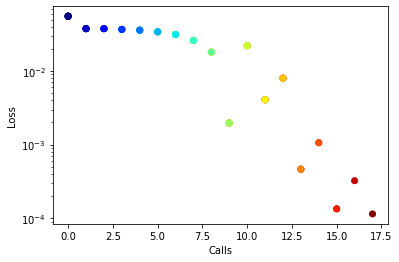

Initial loss is 0.055615234056439755
initial guess is [0.01789544]


 20%|██        | 1/5 [00:34<02:19, 34.82s/it]

Test 0 success True
Initial motor positions are [0.08345434]


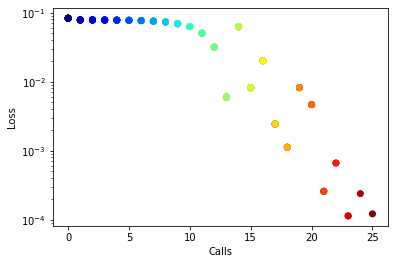

Initial loss is 0.0831750918367641
initial guess is [-0.00466034]


 40%|████      | 2/5 [01:22<02:06, 42.28s/it]

Test 1 success True
Initial motor positions are [0.00248718]


''

Initial loss is 0.00255069818768662
Initial guess [0.17960112] produces beam out of bounds. Trying another guess.
initial guess is [0.14588703]


 40%|████      | 2/5 [01:32<02:18, 46.23s/it]


Exception: Unconsistend calculation: Diffraction plane is set on Z, but the beam has no extention in that direction

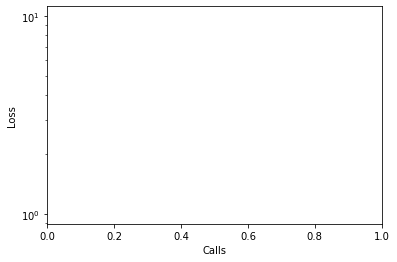

In [45]:
%%time
initial_centroids = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_centroids = []
final_out_beams = []

min_trans = -0.2
max_trans = 0.2

for outer in tqdm(range(5)):
    translations = np.random.uniform(min_trans, max_trans, size=1)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)
    
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                          motor_types=move_motors, 
                                          initial_motor_positions=test_absolute_movements, 
                                          random_seed=DEFAULT_RANDOM_SEED)
    
    plot_callback = LivePlotCallback(opt_trial)
    opt_results, guesses, solution, success = opt_trial.trials(verbose=False, 
                                                               guess_min=min_trans, 
                                                               guess_max=max_trans,
                                                               optimizer_extra_options={
                                                                   'callback':plot_callback.live_plot})
    plot_callback.close()
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')

#### Applying tolerances:
xatol : (tolerance in x-motion) of 0.25 $\mu$m, which is the resolution of the motors in the experiment.

In [28]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

0it [00:00, ?it/s]

Initial loss is 0.0004961451730799435
initial guess is [0.10579797]


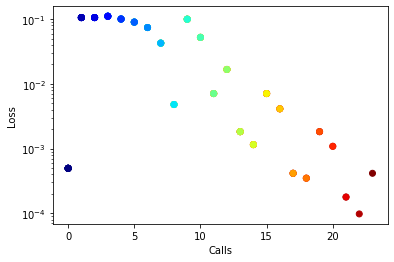

1it [00:43, 43.34s/it]

Test 0 success True
Initial loss is 0.11728418077173441
initial guess is [0.15838178]


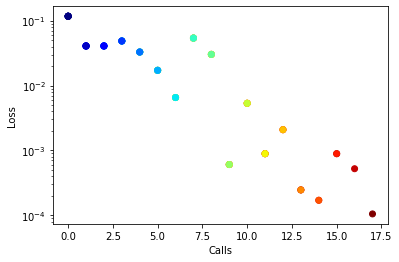

2it [01:14, 36.07s/it]

Test 1 success True
Initial loss is 0.11961891315249279
initial guess is [0.09551436]


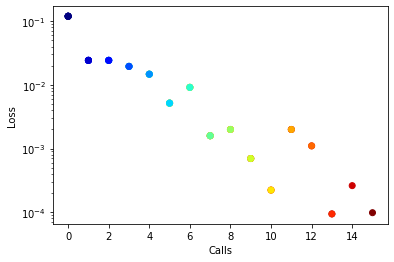

3it [01:42, 32.28s/it]

Test 2 success True
Initial loss is 0.14069582408529052
initial guess is [-0.07723993]


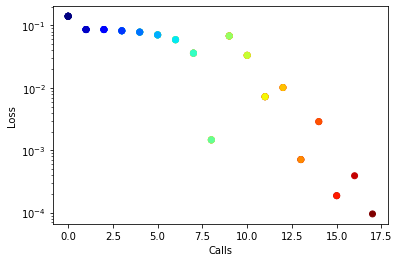

4it [02:12, 31.55s/it]

Test 3 success True
Initial loss is 0.19013405746706147
Initial guess [-0.10048333] produces beam out of bounds. Trying another guess.
Initial guess [-0.05407488] produces beam out of bounds. Trying another guess.
Initial guess [-0.12382238] produces beam out of bounds. Trying another guess.
Initial guess [-0.16664482] produces beam out of bounds. Trying another guess.
Initial guess [-0.18930658] produces beam out of bounds. Trying another guess.
Initial guess [-0.13632049] produces beam out of bounds. Trying another guess.
initial guess is [0.17065504]


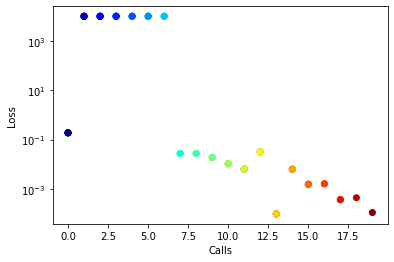

5it [02:37, 31.50s/it]

Test 4 success True
CPU times: user 2min 30s, sys: 16.9 s, total: 2min 47s
Wall time: 2min 37s


In [29]:
%%time
start_guesses2 = []
overall_successes2 = []
final_out_beams2 = []
for outer, test_absolute_movements in tqdm(enumerate(absolute_movements)):
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED, 
                                              default_opt_params={'xatol':0.25e-3})
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=False, guess_min=min_trans, guess_max=max_trans,
                                                               optimizer_extra_options={
                                                                   'callback':opt_trial.live_plot_loss_callback})
    plt.close()
    focusing_system = opt_trial.focusing_system
    
    start_guesses2.append(guesses)
    overall_successes2.append(success)
    final_out_beams2.append(out_beam)
    print(f'Test {outer} success {success}')
    

In [18]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [19]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [20]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [21]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

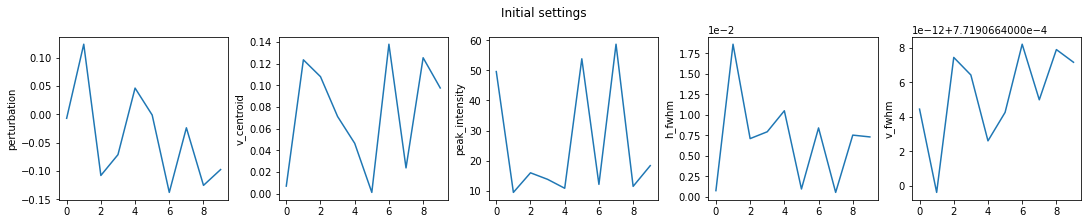

In [25]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

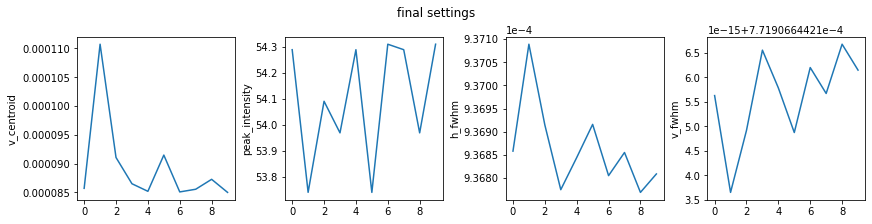

In [26]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

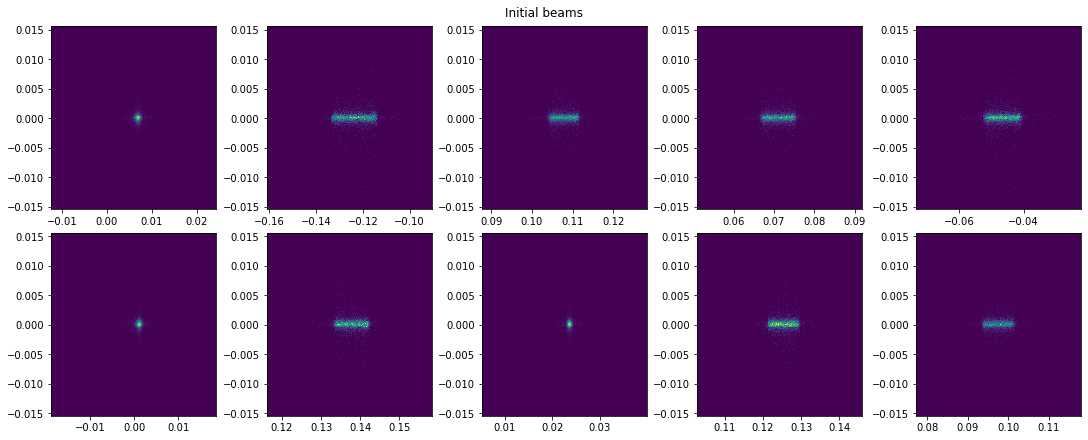

In [27]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

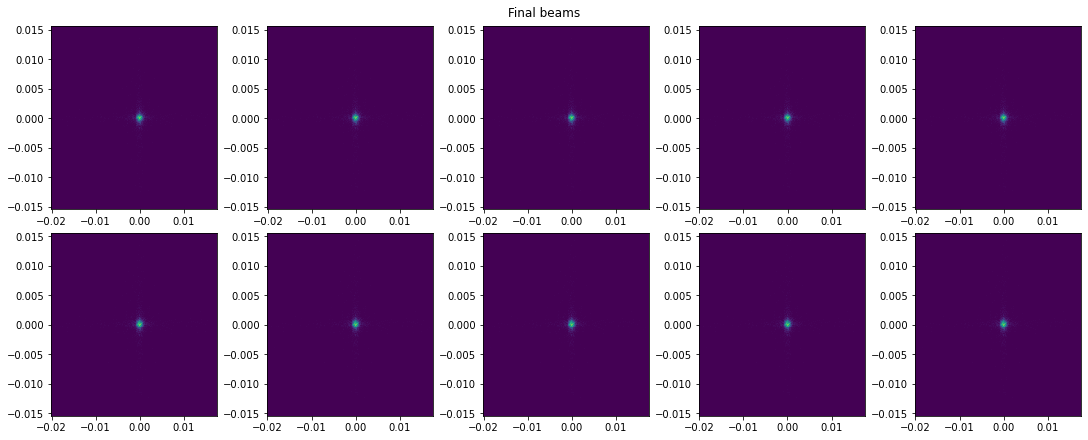

In [28]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

In [29]:
clean_up()

In [30]:
shutil.rmtree(temp_work_dir)